### Importing necessary libraries

In [396]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import gui
from myshow import myshow, myshow3d
import os
import skimage
import numpy as np
from scipy import linalg
import time

### Fast Marching Segmentation on 4 Patient Data

#### Patient 01

In [412]:
start1 = time.time()

In [413]:
#Reading in the scan and the three segmentations for first patient
img01 = sitk.ReadImage("Liver Data/Patient_1/Patient01Homo.mha")
img01_seg_01 = sitk.ReadImage("Liver Data/Patient_1/Patient01Homo_Rad01.mha")
img01_seg_02 = sitk.ReadImage("Liver Data/Patient_1/Patient01Homo_Rad02.mha")
img01_seg_03 = sitk.ReadImage("Liver Data/Patient_1/Patient01Homo_Rad03.mha")

#Rescaling intensities
img01_255 = sitk.Cast(sitk.RescaleIntensity(img01), sitk.sitkUInt8)
img01_seg_01_255 = sitk.Cast(sitk.RescaleIntensity(img01_seg_01), sitk.sitkUInt8)
img01_seg_02_255 = sitk.Cast(sitk.RescaleIntensity(img01_seg_02), sitk.sitkUInt8)
img01_seg_03_255 = sitk.Cast(sitk.RescaleIntensity(img01_seg_02), sitk.sitkUInt8)

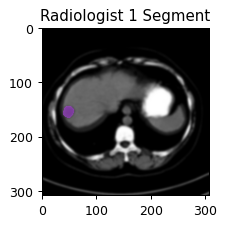

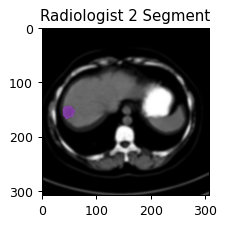

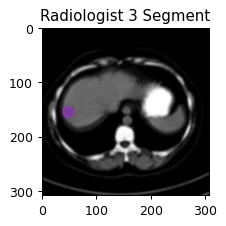

In [414]:
#Visualising the radiologists segments
myshow3d(sitk.LabelOverlay(img01_255, img01_seg_01_255),zslices=[74],title='Radiologist 1 Segment',dpi=90,margin=0.05)
myshow3d(sitk.LabelOverlay(img01_255, img01_seg_02_255),zslices=[74],title='Radiologist 2 Segment',dpi=90,margin=0.05)
myshow3d(sitk.LabelOverlay(img01_255, img01_seg_03_255),zslices=[74],title='Radiologist 3 Segment',dpi=90,margin=0.05)

In [415]:
#setting the seed:
seed = (27,88,74)

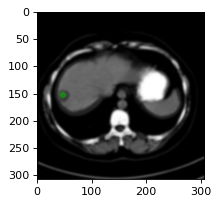

In [416]:
seed = (27,88,74)
seg = sitk.Image(img01.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img01)
seg[seed] = 1
seg = sitk.BinaryDilate(seg, (3,3,3))

myshow3d(sitk.LabelOverlay(img01_255, seg), zslices=[74])

In [417]:
result01 = []

for sigma in [0.1,0.2,0.3,0.5]:
    gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
    gradientMagnitude.SetSigma(sigma)
    gradientMagnitudeOutput = gradientMagnitude.Execute(img01_255)
    sigmoid = sitk.SigmoidImageFilter()
    sigmoid.SetOutputMinimum(0.0)
    sigmoid.SetOutputMaximum(1.0)
    for alpha in [0.1,0.2,0.3,0.5]:
        sigmoid.SetAlpha( alpha )
        for beta in [0.1,0.2,0.3,0.5]:
            sigmoid.SetBeta(beta)
            sigmoid.DebugOn()
            trialPoint = (27, 88, 74)           
            timeThreshold = 15
            stoppingTime = 1000
            sigmoidOutput = sigmoid.Execute(gradientMagnitudeOutput)
            fastMarching = sitk.FastMarchingImageFilter()
            fastMarching.AddTrialPoint(trialPoint)
            fastMarching.SetStoppingValue(stoppingTime)
            fastMarchingOutput = fastMarching.Execute(sigmoidOutput)
            thresholder = sitk.BinaryThresholdImageFilter()
            thresholder.SetLowerThreshold(0.0)
            thresholder.SetUpperThreshold(12)
            thresholder.SetOutsideValue(0)
            thresholder.SetInsideValue(255)
            result01.append(thresholder.Execute(fastMarchingOutput)) 


### Validation: 

#### Choose the reference segment image using majority vote between the three radiologists segments

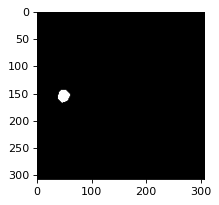

In [418]:
labelForUndecidedPixels = 10
reference_segmentation_majority_vote = sitk.LabelVoting([img01_seg_01,img01_seg_02,img01_seg_03], labelForUndecidedPixels) 
reference_segmentation_majority_vote_255 = sitk.Cast(sitk.RescaleIntensity(reference_segmentation_majority_vote), sitk.sitkUInt8)
myshow3d(reference_segmentation_majority_vote_255,zslices=[74])

In [419]:
from enum import Enum

# Use enumerations to represent the various evaluation measures
class OverlapMeasures(Enum):
    jaccard, dice = range(2)

class SurfaceDistanceMeasures(Enum):
    hausdorff_distance, mean_surface_distance, median_surface_distance, std_surface_distance, max_surface_distance = range(5)
segmentations=result01   
# Select which reference we want to use (majority vote or STAPLE)    
reference_segmentation = reference_segmentation_majority_vote_255
# Empty numpy arrays to hold the results 
overlap_results = np.zeros((len(segmentations),len(OverlapMeasures.__members__.items())))  
surface_distance_results = np.zeros((len(segmentations),len(SurfaceDistanceMeasures.__members__.items())))  

# Compute the evaluation criteria

# Note that for the overlap measures filter, because we are dealing with a single label we 
# use the combined, all labels, evaluation measures without passing a specific label to the methods.
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()

# Use the absolute values of the distance map to compute the surface distances (distance map sign, outside or inside 
# relationship, is irrelevant)
label = 1
reference_distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(reference_segmentation, squaredDistance=False, useImageSpacing=True))
reference_surface = sitk.LabelContour(reference_segmentation)

statistics_image_filter = sitk.StatisticsImageFilter()
# Get the number of pixels in the reference surface by counting all pixels that are 1.
statistics_image_filter.Execute(reference_surface)
num_reference_surface_pixels = int(statistics_image_filter.GetSum()) 

for i, seg in enumerate(segmentations):
    # Overlap measures
    overlap_measures_filter.Execute(reference_segmentation, seg)
    overlap_results[i,OverlapMeasures.jaccard.value] = overlap_measures_filter.GetJaccardCoefficient()
    overlap_results[i,OverlapMeasures.dice.value] = overlap_measures_filter.GetDiceCoefficient()

In [420]:
import pandas as pd
from IPython.display import display, HTML 

# Graft our results matrix into pandas data frames 
overlap_results_df = pd.DataFrame(data=overlap_results, index = list(range(len(segmentations))), 
                                  columns=[name for name, _ in OverlapMeasures.__members__.items()]) 

# Display the data as HTML tables and graphs
display(HTML(overlap_results_df.to_html(float_format=lambda x: '%.3f' % x)))


,jaccard,dice
0,0.561,0.719
1,0.559,0.717
2,0.558,0.716
3,0.554,0.713
4,0.556,0.715
5,0.555,0.714
6,0.554,0.713
7,0.546,0.706
8,0.552,0.711
9,0.547,0.707


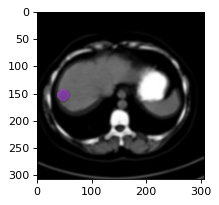

In [421]:
myshow3d(sitk.LabelOverlay(img01_255, result01[0]), zslices=[74])

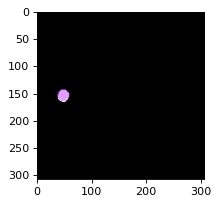

In [422]:
myshow3d(sitk.LabelOverlay(img01_seg_01_255, result01[0]), zslices=[74])

In [423]:
end1 = time.time()
print(f"Runtime of the program is {(end1 - start1)}")

Runtime of the program is 420.7444489002228


In [317]:
sitk.WriteImage(result01[0], os.path.join('Output_Liver Tumor/Patient_1', 'Patient1_fm.nrrd'))
sitk.WriteImage(result01[0], os.path.join('Output_Liver Tumor/Patient_1', 'Patient_fm.mha'))

#### Patient 02

In [59]:
#Reading in the scan and the three segmentations for first patient
img02 = sitk.ReadImage("Liver Data/Patient_2/Patient02Homo.mha")
img02_seg_01 = sitk.ReadImage("Liver Data/Patient_2/Patient02Homo_Rad01.mha")
img02_seg_02 = sitk.ReadImage("Liver Data/Patient_2/Patient02Homo_Rad02.mha")
img02_seg_03 = sitk.ReadImage("Liver Data/Patient_2/Patient02Homo_Rad03.mha")

#Rescaling intensities
img02_255 = sitk.Cast(sitk.RescaleIntensity(img02), sitk.sitkUInt8)
img02_seg_01_255 = sitk.Cast(sitk.RescaleIntensity(img02_seg_01), sitk.sitkUInt8)
img02_seg_02_255 = sitk.Cast(sitk.RescaleIntensity(img02_seg_02), sitk.sitkUInt8)
img02_seg_03_255 = sitk.Cast(sitk.RescaleIntensity(img02_seg_02), sitk.sitkUInt8)

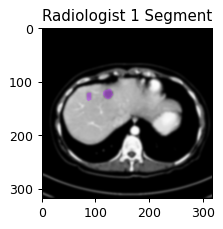

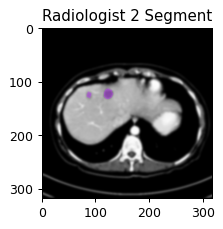

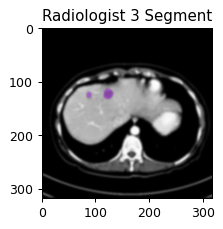

In [151]:
#Visualising the radiologists segments
myshow3d(sitk.LabelOverlay(img02_255, img02_seg_01_255),zslices=[216],title='Radiologist 1 Segment',dpi=90,margin=0.05)
myshow3d(sitk.LabelOverlay(img02_255, img02_seg_02_255),zslices=[216],title='Radiologist 2 Segment',dpi=90,margin=0.05)
myshow3d(sitk.LabelOverlay(img02_255, img02_seg_03_255),zslices=[216],title='Radiologist 3 Segment',dpi=90,margin=0.05)

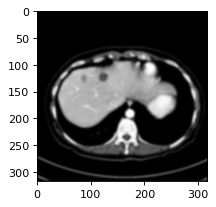

In [66]:
myshow3d(img02_255,zslices=[216])

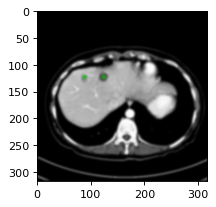

In [92]:
seed1 = (70,70,216)
seed2 = (50,70,216)
seg = sitk.Image(img02.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img02)
seg[seed1] = 1
seg[seed2] = 1
seg = sitk.BinaryDilate(seg, (2,2,2))

myshow3d(sitk.LabelOverlay(img02_255, seg), zslices=[216])

In [158]:
result02 = []
for sigma in [0.1,0.2,0.3,0.5]:
    gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
    gradientMagnitude.SetSigma(sigma)
    gradientMagnitudeOutput = gradientMagnitude.Execute(img02_255)
    sigmoid = sitk.SigmoidImageFilter()
    sigmoid.SetOutputMinimum(0.0)
    sigmoid.SetOutputMaximum(1.0)
    for alpha in [0.1,0.2,0.3,0.5]:
        sigmoid.SetAlpha(alpha)
        for beta in [0.1,0.2,0.3,0.5]:
            sigmoid.SetBeta(beta)
            sigmoid.DebugOn()
            trialPoint1 = (70, 70, 216) 
            #trialPoint2 = (50, 70, 216)  
            timeThreshold = 15
            stoppingTime = 100
            sigmoidOutput = sigmoid.Execute(gradientMagnitudeOutput)
            fastMarching = sitk.FastMarchingImageFilter()
            fastMarching.AddTrialPoint(trialPoint1)
            fastMarching.AddTrialPoint(trialPoint2)
            fastMarching.SetStoppingValue(stoppingTime)
            fastMarchingOutput = fastMarching.Execute(sigmoidOutput)
            thresholder = sitk.BinaryThresholdImageFilter()
            thresholder.SetLowerThreshold(0.0)
            thresholder.SetUpperThreshold(10)
            thresholder.SetOutsideValue(0)
            thresholder.SetInsideValue(255)
            result02.append(thresholder.Execute(fastMarchingOutput)) 


### Validation: 

#### Choose the reference segment image using majority vote between the three radiologists segments

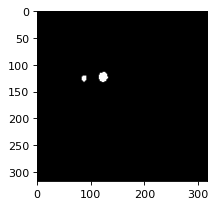

In [159]:
labelForUndecidedPixels = 10
reference_segmentation_majority_vote = sitk.LabelVoting([img02_seg_01,img02_seg_02,img02_seg_03], labelForUndecidedPixels) 
reference_segmentation_majority_vote_255 = sitk.Cast(sitk.RescaleIntensity(reference_segmentation_majority_vote), sitk.sitkUInt8)
myshow3d(reference_segmentation_majority_vote_255,zslices=[216])

In [160]:
from enum import Enum

# Use enumerations to represent the various evaluation measures
class OverlapMeasures(Enum):
    jaccard, dice = range(2)
segmentations=result02   
# Select which reference we want to use (majority vote or STAPLE)    
reference_segmentation = reference_segmentation_majority_vote_255
# Empty numpy arrays to hold the results 
overlap_results = np.zeros((len(segmentations),len(OverlapMeasures.__members__.items())))  

# Compute the evaluation criteria

# Note that for the overlap measures filter, because we are dealing with a single label we 
# use the combined, all labels, evaluation measures without passing a specific label to the methods.
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()


# Use the absolute values of the distance map to compute the surface distances (distance map sign, outside or inside 
# relationship, is irrelevant)
label = 1
reference_distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(reference_segmentation, squaredDistance=False, useImageSpacing=True))
reference_surface = sitk.LabelContour(reference_segmentation)

statistics_image_filter = sitk.StatisticsImageFilter()
# Get the number of pixels in the reference surface by counting all pixels that are 1.
statistics_image_filter.Execute(reference_surface)
num_reference_surface_pixels = int(statistics_image_filter.GetSum()) 

for i, seg in enumerate(segmentations):
    # Overlap measures
    overlap_measures_filter.Execute(reference_segmentation, seg)
    overlap_results[i,OverlapMeasures.jaccard.value] = overlap_measures_filter.GetJaccardCoefficient()
    overlap_results[i,OverlapMeasures.dice.value] = overlap_measures_filter.GetDiceCoefficient()

In [161]:
import pandas as pd
from IPython.display import display, HTML 

# Graft our results matrix into pandas data frames 
overlap_results_df = pd.DataFrame(data=overlap_results, index = list(range(len(segmentations))), 
                                  columns=[name for name, _ in OverlapMeasures.__members__.items()]) 

# Display the data as HTML tables and graphs
display(HTML(overlap_results_df.to_html(float_format=lambda x: '%.3f' % x)))

,jaccard,dice
0,0.468,0.637
1,0.468,0.637
2,0.469,0.638
3,0.461,0.631
4,0.469,0.639
5,0.468,0.638
6,0.464,0.634
7,0.456,0.626
8,0.466,0.635
9,0.460,0.631


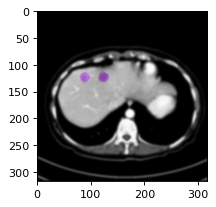

In [306]:
myshow3d(sitk.LabelOverlay(img02_255, result02[4]), zslices=[216])

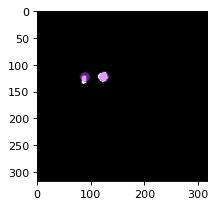

In [309]:
myshow3d(sitk.LabelOverlay(img02_seg_01_255, result02[4]), zslices=[216])

In [318]:
sitk.WriteImage(result02[4], os.path.join('Output_Liver Tumor/Patient_2', 'Patient2_fm.nrrd'))
sitk.WriteImage(result02[4], os.path.join('Output_Liver Tumor/Patient_2', 'Patient2_fm.mha'))

#### Patient 03

In [163]:
#Reading in the scan and the three segmentations for first patient
img03 = sitk.ReadImage("Liver Data/Patient_3/Patient03Homo.mha")
img03_seg_01 = sitk.ReadImage("Liver Data/Patient_3/Patient03Homo_Rad01.mha")
img03_seg_02 = sitk.ReadImage("Liver Data/Patient_3/Patient03Homo_Rad02.mha")
img03_seg_03 = sitk.ReadImage("Liver Data/Patient_3/Patient03Homo_Rad03.mha")

#Rescaling intensities
img03_255 = sitk.Cast(sitk.RescaleIntensity(img03), sitk.sitkUInt8)
img03_seg_01_255 = sitk.Cast(sitk.RescaleIntensity(img03_seg_01), sitk.sitkUInt8)
img03_seg_02_255 = sitk.Cast(sitk.RescaleIntensity(img03_seg_02), sitk.sitkUInt8)
img03_seg_03_255 = sitk.Cast(sitk.RescaleIntensity(img03_seg_02), sitk.sitkUInt8)

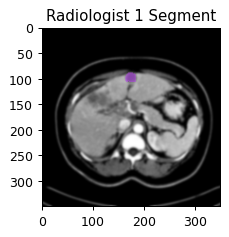

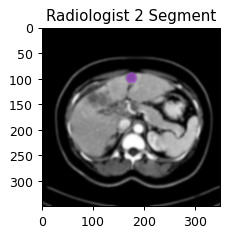

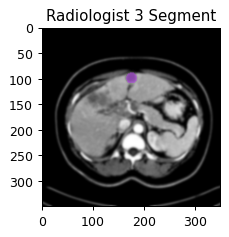

In [164]:
#Visualising the radiologists segments
myshow3d(sitk.LabelOverlay(img03_255, img03_seg_01_255),zslices=[198],title='Radiologist 1 Segment',dpi=90,margin=0.05)
myshow3d(sitk.LabelOverlay(img03_255, img03_seg_02_255),zslices=[198],title='Radiologist 2 Segment',dpi=90,margin=0.05)
myshow3d(sitk.LabelOverlay(img03_255, img03_seg_03_255),zslices=[198],title='Radiologist 3 Segment',dpi=90,margin=0.05)

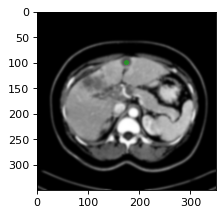

In [176]:
seed = (94,54,198)
seg = sitk.Image(img03.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img03)
seg[seed] = 1
seg = sitk.BinaryDilate(seg, (2,2,2))

myshow3d(sitk.LabelOverlay(img03_255, seg), zslices=[198])

In [206]:
result03 = []
for sigma in [0.1,0.2,0.3,0.5]:
    gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
    gradientMagnitude.SetSigma(sigma)
    gradientMagnitudeOutput = gradientMagnitude.Execute(img03_255)
    sigmoid = sitk.SigmoidImageFilter()
    sigmoid.SetOutputMinimum(0.0)
    sigmoid.SetOutputMaximum(1.0)
    for alpha in [0.1,0.2,0.3,0.5]:
        sigmoid.SetAlpha(alpha)
        for beta in [0.1,0.2,0.3,0.5]:
            sigmoid.SetBeta(beta)
            sigmoid.DebugOn()
            trialPoint = (94, 54, 198)           
            timeThreshold = 15
            stoppingTime = 100
            sigmoidOutput = sigmoid.Execute(gradientMagnitudeOutput)
            fastMarching = sitk.FastMarchingImageFilter()
            fastMarching.AddTrialPoint(trialPoint)
            fastMarching.SetStoppingValue(stoppingTime)
            fastMarchingOutput = fastMarching.Execute(sigmoidOutput)
            thresholder = sitk.BinaryThresholdImageFilter()
            thresholder.SetLowerThreshold(0.0)
            thresholder.SetUpperThreshold(11)
            thresholder.SetOutsideValue(0)
            thresholder.SetInsideValue(255)
            result03.append(thresholder.Execute(fastMarchingOutput)) 


### Validation: 
#### Choose the reference segment image using majority vote between the three radiologists segments

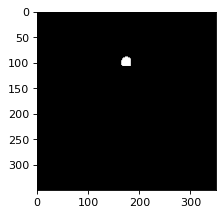

In [196]:
labelForUndecidedPixels = 10
reference_segmentation_majority_vote = sitk.LabelVoting([img03_seg_01,img03_seg_02,img03_seg_03], labelForUndecidedPixels) 
reference_segmentation_majority_vote_255 = sitk.Cast(sitk.RescaleIntensity(reference_segmentation_majority_vote), sitk.sitkUInt8)
myshow3d(reference_segmentation_majority_vote_255,zslices=[198])

In [220]:
from enum import Enum

# Use enumerations to represent the various evaluation measures
class OverlapMeasures(Enum):
    jaccard, dice = range(2)
segmentations=result03  
# Select which reference we want to use (majority vote or STAPLE)    
reference_segmentation = reference_segmentation_majority_vote_255
# Empty numpy arrays to hold the results 
overlap_results = np.zeros((len(segmentations),len(OverlapMeasures.__members__.items())))  

# Compute the evaluation criteria

# Note that for the overlap measures filter, because we are dealing with a single label we 
# use the combined, all labels, evaluation measures without passing a specific label to the methods.
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()


# Use the absolute values of the distance map to compute the surface distances (distance map sign, outside or inside 
# relationship, is irrelevant)
label = 1
reference_distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(reference_segmentation, squaredDistance=False, useImageSpacing=True))
reference_surface = sitk.LabelContour(reference_segmentation)

statistics_image_filter = sitk.StatisticsImageFilter()
# Get the number of pixels in the reference surface by counting all pixels that are 1.
statistics_image_filter.Execute(reference_surface)
num_reference_surface_pixels = int(statistics_image_filter.GetSum()) 

for i, seg in enumerate(segmentations):
    # Overlap measures
    overlap_measures_filter.Execute(reference_segmentation, seg)
    overlap_results[i,OverlapMeasures.jaccard.value] = overlap_measures_filter.GetJaccardCoefficient()
    overlap_results[i,OverlapMeasures.dice.value] = overlap_measures_filter.GetDiceCoefficient()

In [221]:
import pandas as pd
from IPython.display import display, HTML 

# Graft our results matrix into pandas data frames 
overlap_results_df = pd.DataFrame(data=overlap_results, index = list(range(len(segmentations))), 
                                  columns=[name for name, _ in OverlapMeasures.__members__.items()]) 

# Display the data as HTML tables and graphs
display(HTML(overlap_results_df.to_html(float_format=lambda x: '%.3f' % x)))

,jaccard,dice
0,0.595,0.746
1,0.595,0.746
2,0.595,0.746
3,0.595,0.746
4,0.595,0.746
5,0.595,0.746
6,0.595,0.746
7,0.587,0.740
8,0.595,0.746
9,0.591,0.743


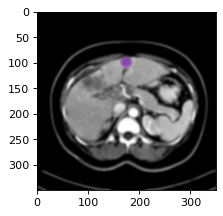

In [310]:
myshow3d(sitk.LabelOverlay(img03_255, result03[0]), zslices=[198])

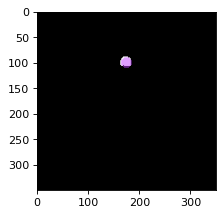

In [311]:
myshow3d(sitk.LabelOverlay(img03_seg_01_255, result03[0]), zslices=[198])

In [319]:
sitk.WriteImage(result03[0], os.path.join('Output_Liver Tumor/Patient_3', 'Patient3_fm.nrrd'))
sitk.WriteImage(result03[0], os.path.join('Output_Liver Tumor/Patient_3', 'Patient3_fm.mha'))

#### Patient 04

In [201]:
#Reading in the scan and the three segmentations for first patient
img04 = sitk.ReadImage("Liver Data/Patient_4/Patient04Homo.mha")
img04_seg_01 = sitk.ReadImage("Liver Data/Patient_4/Patient04Homo_Rad01.mha")
img04_seg_02 = sitk.ReadImage("Liver Data/Patient_4/Patient04Homo_Rad02.mha")
img04_seg_03 = sitk.ReadImage("Liver Data/Patient_4/Patient04Homo_Rad03.mha")

#Rescaling intensities
img04_255 = sitk.Cast(sitk.RescaleIntensity(img04), sitk.sitkUInt8)
img04_seg_01_255 = sitk.Cast(sitk.RescaleIntensity(img04_seg_01), sitk.sitkUInt8)
img04_seg_02_255 = sitk.Cast(sitk.RescaleIntensity(img04_seg_02), sitk.sitkUInt8)
img04_seg_03_255 = sitk.Cast(sitk.RescaleIntensity(img04_seg_02), sitk.sitkUInt8)

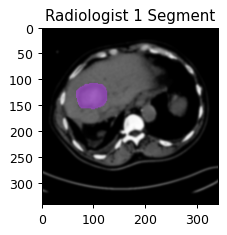

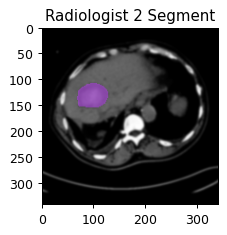

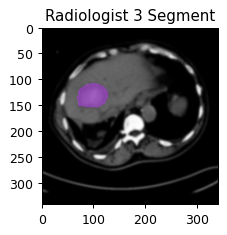

In [208]:
#Visualising the radiologists segments
myshow3d(sitk.LabelOverlay(img04_255, img04_seg_01_255),zslices=[85],title='Radiologist 1 Segment',dpi=90,margin=0.05)
myshow3d(sitk.LabelOverlay(img04_255, img04_seg_02_255),zslices=[85],title='Radiologist 2 Segment',dpi=90,margin=0.05)
myshow3d(sitk.LabelOverlay(img04_255, img04_seg_03_255),zslices=[85],title='Radiologist 3 Segment',dpi=90,margin=0.05)

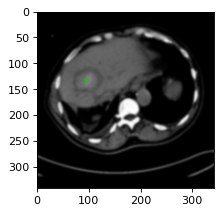

In [254]:
seed = (52,73,85)
seg = sitk.Image(img04.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img04)
seg[seed] = 1
seg = sitk.BinaryDilate(seg, (2,2,2))

myshow3d(sitk.LabelOverlay(img04_255, seg), zslices=[85])

### Validation: 
#### Choose the reference segment image using majority vote between the three radiologists segments

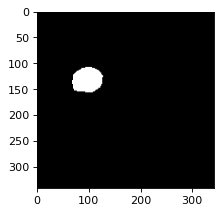

In [230]:
labelForUndecidedPixels = 10
reference_segmentation_majority_vote = sitk.LabelVoting([img04_seg_01,img04_seg_02,img04_seg_03], labelForUndecidedPixels) 
reference_segmentation_majority_vote_255 = sitk.Cast(sitk.RescaleIntensity(reference_segmentation_majority_vote), sitk.sitkUInt8)
myshow3d(reference_segmentation_majority_vote_255,zslices=[85])

In [255]:
result04 = []
for sigma in [0.1,0.2,0.3,0.5]:
    gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
    gradientMagnitude.SetSigma(sigma)
    gradientMagnitudeOutput = gradientMagnitude.Execute(img04_255)
    sigmoid = sitk.SigmoidImageFilter()
    sigmoid.SetOutputMinimum(0.0)
    sigmoid.SetOutputMaximum(1.0)
    for alpha in [0.1,0.2,0.3,0.5]:
        sigmoid.SetAlpha(alpha)
        for beta in [0.1,0.2,0.3,0.5]:
            sigmoid.SetBeta(beta)
            sigmoid.DebugOn()
            trialPoint = (52, 73, 85)           
            timeThreshold = 15
            stoppingTime = 100
            sigmoidOutput = sigmoid.Execute(gradientMagnitudeOutput)
            fastMarching = sitk.FastMarchingImageFilter()
            fastMarching.AddTrialPoint(trialPoint)
            fastMarching.SetStoppingValue(stoppingTime)
            fastMarchingOutput = fastMarching.Execute(sigmoidOutput)
            thresholder = sitk.BinaryThresholdImageFilter()
            thresholder.SetLowerThreshold(0.0)
            thresholder.SetUpperThreshold(30)
            thresholder.SetOutsideValue(0)
            thresholder.SetInsideValue(255)
            result04.append(thresholder.Execute(fastMarchingOutput)) 


In [257]:
from enum import Enum

# Use enumerations to represent the various evaluation measures
class OverlapMeasures(Enum):
    jaccard, dice = range(2)
segmentations=result04  
# Select which reference we want to use (majority vote or STAPLE)    
reference_segmentation = reference_segmentation_majority_vote_255
# Empty numpy arrays to hold the results 
overlap_results = np.zeros((len(segmentations),len(OverlapMeasures.__members__.items())))  

# Compute the evaluation criteria

# Note that for the overlap measures filter, because we are dealing with a single label we 
# use the combined, all labels, evaluation measures without passing a specific label to the methods.
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()


# Use the absolute values of the distance map to compute the surface distances (distance map sign, outside or inside 
# relationship, is irrelevant)
label = 1
reference_distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(reference_segmentation, squaredDistance=False, useImageSpacing=True))
reference_surface = sitk.LabelContour(reference_segmentation)

statistics_image_filter = sitk.StatisticsImageFilter()
# Get the number of pixels in the reference surface by counting all pixels that are 1.
statistics_image_filter.Execute(reference_surface)
num_reference_surface_pixels = int(statistics_image_filter.GetSum()) 

for i, seg in enumerate(segmentations):
    # Overlap measures
    overlap_measures_filter.Execute(reference_segmentation, seg)
    overlap_results[i,OverlapMeasures.jaccard.value] = overlap_measures_filter.GetJaccardCoefficient()
    overlap_results[i,OverlapMeasures.dice.value] = overlap_measures_filter.GetDiceCoefficient()

In [258]:
import pandas as pd
from IPython.display import display, HTML 

# Graft our results matrix into pandas data frames 
overlap_results_df = pd.DataFrame(data=overlap_results, index = list(range(len(segmentations))), 
                                  columns=[name for name, _ in OverlapMeasures.__members__.items()]) 

# Display the data as HTML tables and graphs
display(HTML(overlap_results_df.to_html(float_format=lambda x: '%.3f' % x)))

,jaccard,dice
0,0.621,0.766
1,0.622,0.767
2,0.623,0.768
3,0.627,0.770
4,0.623,0.768
5,0.625,0.769
6,0.628,0.771
7,0.632,0.775
8,0.629,0.772
9,0.631,0.773


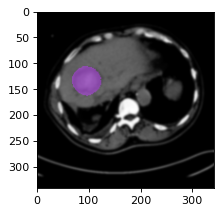

In [312]:
myshow3d(sitk.LabelOverlay(img04_255, result04[15]), zslices=[85])

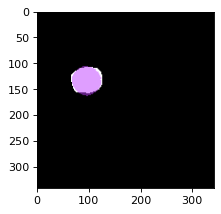

In [316]:
myshow3d(sitk.LabelOverlay(img04_seg_01_255, result04[15]), zslices=[85])

In [320]:
sitk.WriteImage(result04[15], os.path.join('Output_Liver Tumor/Patient_4', 'Patient4_fm.nrrd'))
sitk.WriteImage(result04[15], os.path.join('Output_Liver Tumor/Patient_4', 'Patient4_fm.mha'))

### Comparison b/w diffferent algorithms

#### Region Growing Segmentation

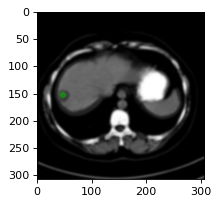

In [259]:
seed = (27,88,74)
seg = sitk.Image(img01.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img01)
seg[seed] = 1
seg = sitk.BinaryDilate(seg, (3,3,3))

myshow3d(sitk.LabelOverlay(img01_255, seg), zslices=[74])

#### 1. Connected Threshold:

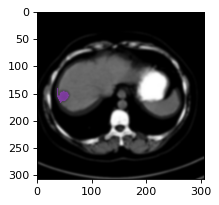

In [261]:
seg1 = sitk.ConnectedThreshold(img01, seedList=[seed], lower=50, upper=70,replaceValue=2)
seg1_255 = sitk.Cast(sitk.RescaleIntensity(seg1), sitk.sitkUInt8)
myshow3d(sitk.LabelOverlay(img01_255, seg1_255), zslices=[74])
sitk.WriteImage(seg1_255, os.path.join('Output_Liver Tumor', 'img_ct.nrrd'))
sitk.WriteImage(seg1, os.path.join('Output_Liver Tumor', 'img_ct.mha'))

#### 2. Confidence Connected:

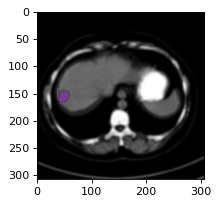

In [266]:
seg2 = sitk.ConfidenceConnected(img01, seedList=[seed],
                                   numberOfIterations=1,
                                   multiplier=2.6,
                                   initialNeighborhoodRadius=1,
                                   replaceValue=2)
seg2_255 = sitk.Cast(sitk.RescaleIntensity(seg2), sitk.sitkUInt8)
myshow3d(sitk.LabelOverlay(img01_255, seg2_255), zslices=[74])
sitk.WriteImage(seg2_255, os.path.join('Output_Liver Tumor', 'img_cc.nrrd'))
sitk.WriteImage(seg2, os.path.join('Output_Liver Tumor', 'img_cc.mha'))

#### 3. Neighborhood Connected:

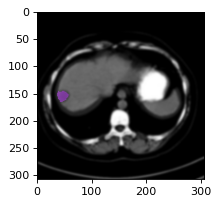

In [268]:
seg3 = sitk.NeighborhoodConnected(img01, seedList=[seed], lower=10, upper=93,replaceValue=2)
seg3_255 = sitk.Cast(sitk.RescaleIntensity(seg3), sitk.sitkUInt8)
myshow3d(sitk.LabelOverlay(img01_255, seg3_255), zslices=[74])
sitk.WriteImage(seg3_255, os.path.join('Output_Liver Tumor', 'img_nc.nrrd'))
sitk.WriteImage(seg3, os.path.join('Output_Liver Tumor', 'img_nc.mha'))

#### Comparison with ground truth:

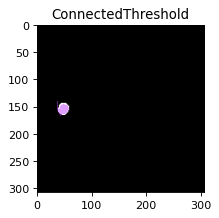

In [278]:
myshow3d(sitk.LabelOverlay(img01_seg_01_255,seg1_255), zslices=[74],title='ConnectedThreshold')

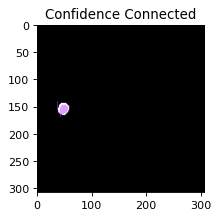

In [279]:
myshow3d(sitk.LabelOverlay(img01_seg_01_255,seg2_255), zslices=[74],title='Confidence Connected')

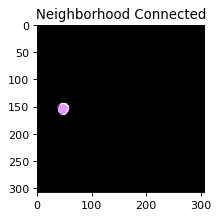

In [280]:
myshow3d(sitk.LabelOverlay(img01_seg_01_255,seg3_255), zslices=[74],title='Neighborhood Connected')

### 4. Level Set Segmentation

In [286]:
seed = (27,88,74)
seg = sitk.Image(img01.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img01)
seg[seed] = 1
seg = sitk.BinaryDilate(seg, (4,4,4))

In [287]:
stats = sitk.LabelStatisticsImageFilter()
stats.Execute(img01, seg)

factor = 2
lower_threshold = stats.GetMean(1)-factor*stats.GetSigma(1)
upper_threshold = stats.GetMean(1)+factor*stats.GetSigma(1)
print(lower_threshold,upper_threshold)


44.01162070258577 76.0397931791623


In [288]:
init_ls = sitk.SignedMaurerDistanceMap(seg, insideIsPositive=True, useImageSpacing=True)

In [289]:
lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter()
lsFilter.SetLowerThreshold(lower_threshold)
lsFilter.SetUpperThreshold(upper_threshold)
lsFilter.SetMaximumRMSError(0.02)
lsFilter.SetNumberOfIterations(500)
lsFilter.SetCurvatureScaling(.5)
lsFilter.SetPropagationScaling(2)
lsFilter.ReverseExpansionDirectionOn()
ls = lsFilter.Execute(init_ls, sitk.Cast(img01, sitk.sitkFloat32))
print(lsFilter)

itk::simple::ThresholdSegmentationLevelSetImageFilter
  LowerThreshold: 44.0116
  UpperThreshold: 76.0398
  MaximumRMSError: 0.02
  PropagationScaling: 2
  CurvatureScaling: 0.5
  NumberOfIterations: 500
  ReverseExpansionDirection: 1
  ElapsedIterations: 64
  RMSChange: 0.0193924
  Debug: 0
  NumberOfThreads: 4
  NumberOfWorkUnits: 0
  Commands: (none)
  ProgressMeasurement: 0.128
  ActiveProcess: (none)



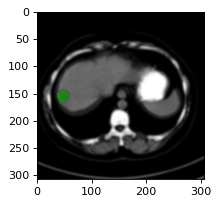

In [291]:
seg4 = ls>0
myshow3d(sitk.LabelOverlay(img01_255, ls>0),zslices=[74])

In [294]:
seg4_255 = sitk.Cast(sitk.RescaleIntensity(seg4), sitk.sitkUInt8)
sitk.WriteImage(seg4_255, os.path.join('Output_Liver Tumor', 'img_ls.nrrd'))
sitk.WriteImage(seg4, os.path.join('Output_Liver Tumor', 'img_ls.mha'))

#### Comparison with ground truth:

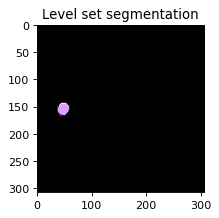

In [295]:
myshow3d(sitk.LabelOverlay(img01_seg_01_255, seg4_255), zslices=[74],title='Level set segmentation')

#### 5. Watershed Segmentation

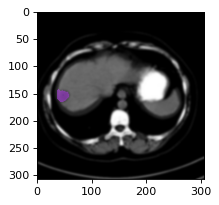

In [300]:
level = 2
imgFeature = sitk.GradientMagnitude(img01_255)

imgWS = sitk.MorphologicalWatershed(imgFeature, level=level, markWatershedLine=True, fullyConnected=False)
seed = (27, 88, 74)
LowerTh, UpperTh = 6200, 6205

segmentationFilter = sitk.ConnectedThresholdImageFilter() 
segmentationFilter.SetLower( float(LowerTh) ) 
segmentationFilter.SetUpper( float(UpperTh) ) 
segmentationFilter.SetReplaceValue( 2 )
segmentationFilter.AddSeed( seed )

# Run the segmentation filter
seg5 = segmentationFilter.Execute( imgWS ) # Apply filter (Segmentate)
seg5[seed]=1
myshow3d(sitk.LabelOverlay(img01_255, seg5_255), zslices=[74])

In [298]:
seg5_255 = sitk.Cast(sitk.RescaleIntensity(seg5), sitk.sitkUInt8)
sitk.WriteImage(seg5_255, os.path.join('Output_Liver Tumor', 'img_ws.nrrd'))
sitk.WriteImage(seg5, os.path.join('Output_Liver Tumor', 'img_ws.mha'))

#### Comparison with ground truth:

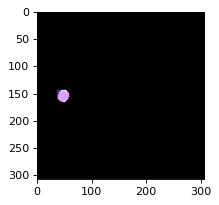

In [299]:
myshow3d(sitk.LabelOverlay(img01_seg_01_255, seg5_255), zslices=[74])

### Comparison using some statistical metrics

In [361]:
from enum import Enum

# Use enumerations to represent the various evaluation measures
class OverlapMeasures(Enum):
    jaccard, dice, volume_similarity, false_negative, false_positive = range(5)

class SurfaceDistanceMeasures(Enum):
    hausdorff_distance, mean_surface_distance, median_surface_distance, std_surface_distance, max_surface_distance = range(5)
segmentations=[seg1_255, result01[1], seg2_255, seg3_255, seg4_255, seg5_255]    
# Select which reference we want to use (majority vote or STAPLE)    
reference_segmentation = img01_seg_02_255
# Empty numpy arrays to hold the results 
overlap_results = np.zeros((len(segmentations),len(OverlapMeasures.__members__.items())))  
surface_distance_results = np.zeros((len(segmentations),len(SurfaceDistanceMeasures.__members__.items())))  

# Compute the evaluation criteria

# Note that for the overlap measures filter, because we are dealing with a single label we 
# use the combined, all labels, evaluation measures without passing a specific label to the methods.
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()

# Use the absolute values of the distance map to compute the surface distances (distance map sign, outside or inside 
# relationship, is irrelevant)
label = 1
reference_distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(reference_segmentation, squaredDistance=False, useImageSpacing=True))
reference_surface = sitk.LabelContour(reference_segmentation)

statistics_image_filter = sitk.StatisticsImageFilter()
# Get the number of pixels in the reference surface by counting all pixels that are 1.
statistics_image_filter.Execute(reference_surface)
num_reference_surface_pixels = int(statistics_image_filter.GetSum()) 

for i, seg in enumerate(segmentations):
    # Overlap measures
    overlap_measures_filter.Execute(reference_segmentation, seg)
    overlap_results[i,OverlapMeasures.jaccard.value] = overlap_measures_filter.GetJaccardCoefficient()
    overlap_results[i,OverlapMeasures.dice.value] = overlap_measures_filter.GetDiceCoefficient()
    overlap_results[i,OverlapMeasures.volume_similarity.value] = overlap_measures_filter.GetVolumeSimilarity()
    overlap_results[i,OverlapMeasures.false_negative.value] = overlap_measures_filter.GetFalseNegativeError()
    overlap_results[i,OverlapMeasures.false_positive.value] = overlap_measures_filter.GetFalsePositiveError()
    
# Print the matrices
np.set_printoptions(precision=3)
print(overlap_results)


[[0.36  0.529 0.274 0.387 0.535]
 [0.553 0.712 0.32  0.152 0.386]
 [0.333 0.499 0.792 0.173 0.642]
 [0.595 0.746 0.339 0.102 0.362]
 [0.565 0.722 0.462 0.062 0.414]
 [0.622 0.767 0.359 0.065 0.35 ]]


,jaccard,dice,volume_similarity,false_negative,false_positive
0,0.360,0.529,0.274,0.387,0.535
1,0.553,0.712,0.320,0.152,0.386
2,0.333,0.499,0.792,0.173,0.642
3,0.595,0.746,0.339,0.102,0.362
4,0.565,0.722,0.462,0.062,0.414
5,0.622,0.767,0.359,0.065,0.350


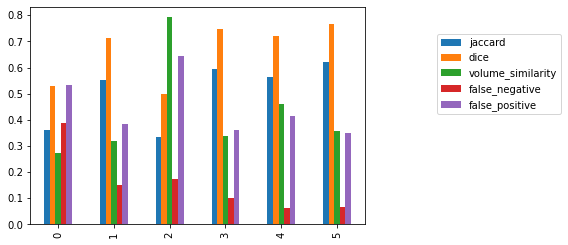

In [362]:
import pandas as pd
from IPython.display import display, HTML 

# Graft our results matrix into pandas data frames 
overlap_results_df = pd.DataFrame(data=overlap_results, index = list(range(len(segmentations))), 
                                  columns=[name for name, _ in OverlapMeasures.__members__.items()]) 

# Display the data as HTML tables and graphs
display(HTML(overlap_results_df.to_html(float_format=lambda x: '%.3f' % x)))

overlap_results_df.plot(kind='bar').legend(bbox_to_anchor=(1.6,0.9))
